# U-Net implementation for competition: 
# https://www.kaggle.com/c/data-science-bowl-2018

In [7]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
import skimage
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

from keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf

# Set some parameters
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
TRAIN_PATH = 'dataset/stage1_train'
TEST_PATH = 'dataset/stage1_test'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 17
random.seed = seed
np.random.seed = seed

## Getting the data

In [4]:
import glob
def get_X_data(path, output_shape=(None, None)):
    img_paths = ['{0}/{1}/images/{1}.png'.format(path, id) for id in os.listdir(path) if not id.startswith('.')]
    X_data = np.array([resize(skimage.io.imread(p)[:,:,:3], output_shape=output_shape, preserve_range=True,
                             mode='constant') 
                       for p in img_paths], dtype=np.uint8)
    return X_data

In [18]:
%%time
X_train = get_X_data(TRAIN_PATH, (256,256))

CPU times: user 14.2 s, sys: 5.15 s, total: 19.4 s
Wall time: 22 s


In [19]:
X_train.shape, X_train.dtype

((670, 256, 256, 3), dtype('uint8'))

In [49]:
%%time
# Get training data labels
def get_Y_data(path, output_shape=(None, None)):
    '''
    Loads and concatenates images from path/{id}/masks/{id}.png into a numpy array
    '''
    img_paths = [glob.glob('{0}/{1}/masks/*.png'.format(path, id)) for id in os.listdir(path)]
    Y_data=[]
    for i, img_masks in tqdm(enumerate(img_paths)):
#         if i == 101: continue
        masks = skimage.io.imread_collection(img_masks)
        masks = masks.concatenate()
        mask = np.max(masks, axis=0)
        mask = resize(mask, output_shape=output_shape+(1,), preserve_range=True, mode='constant')
        Y_data.append(mask)
    Y_data = np.array(Y_data, dtype=np.bool)
        
    return Y_data
Y_train = get_Y_data(TRAIN_PATH, output_shape=(IMG_HEIGHT,IMG_WIDTH))
print(Y_train.shape, Y_train.dtype)

671it [02:52,  3.88it/s]


(670, 256, 256, 1) bool
CPU times: user 1min 18s, sys: 31.1 s, total: 1min 49s
Wall time: 2min 53s


In [50]:
Y_train.shape

(670, 256, 256, 1)

## The second method to import the training and test data

In [3]:
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [4]:
# # Get and resize train images and masks
# X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
# Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
# print('Getting and resizing train images and masks ... ')
# sys.stdout.flush()
# for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
#     path = TRAIN_PATH + "/" + id_
#     img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
#     img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
#     X_train[n] = img
#     mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
#     for mask_file in next(os.walk(path + '/masks/'))[2]:
#         mask_ = imread(path + '/masks/' + mask_file)
#         mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
#                                       preserve_range=True), axis=-1)
#         mask = np.maximum(mask, mask_)
#     Y_train[n] = mask
# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + '/' + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img
print('Done!')

Getting and resizing test images ... 


100%|██████████| 65/65 [00:02<00:00, 31.70it/s]

Done!


In [4]:


print('Done!')

Getting and resizing test images ... 


100%|██████████| 65/65 [00:01<00:00, 36.80it/s]

Done!


In [7]:
X_train.shape, Y_train.shape, X_test.shape

((670, 256, 256, 3), (670, 256, 256, 1), (65, 256, 256, 3))

#### Showing some training examples

(256, 256, 3)


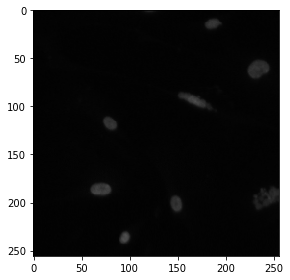

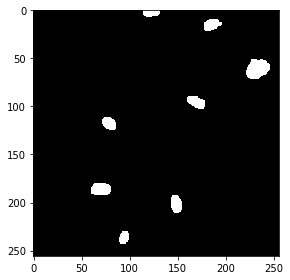

In [8]:
id = 65
print(X_train[id].shape)
skimage.io.imshow(X_train[id])
plt.show()
skimage.io.imshow(Y_train[id][:,:,0])
plt.show()

## Creating the model U-net

In [10]:
from keras import regularizers
def u_net_model(img_shape, verbose=1):
    inputs = Input(img_shape)
    s = Lambda(lambda x: x / 255) (inputs)

    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
    c1 = Dropout(0.1) (c1)
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
    c2 = Dropout(0.1) (c2)
    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
    c3 = Dropout(0.2) (c3)
    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
    c4 = Dropout(0.2) (c4)
    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
    c5 = Dropout(0.3) (c5)
    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
    c6 = Dropout(0.2) (c6)
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
    c7 = Dropout(0.2) (c7)
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
    c8 = Dropout(0.1) (c8)
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
    c9 = Dropout(0.1) (c9)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    if verbose == 1:
        model.summary()

    return model
    
    

In [11]:
model = u_net_model((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 16) 448         lambda_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 256, 256, 16) 0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

### Define IoU metric

In [2]:
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

### Fitting the model

In [13]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])

In [20]:
with tf.device('/gpu:0'):    
    earlystopper = EarlyStopping(patience=5, verbose=1)
    checkpointer = ModelCheckpoint('model-dsbowl2018-1.h5', verbose=1, save_best_only=True)
    results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=50, 
                        callbacks=[earlystopper, checkpointer])

Train on 603 samples, validate on 67 samples
Epoch 1/50
603/603 [==============================] - 951s 2s/step - loss: 0.4047 - mean_iou: 0.4204 - val_loss: 0.2174 - val_mean_iou: 0.4451
Epoch 2/50
603/603 [==============================] - 950s 2s/step - loss: 0.2447 - mean_iou: 0.4754 - val_loss: 0.1615 - val_mean_iou: 0.5050
Epoch 3/50
603/603 [==============================] - 949s 2s/step - loss: 0.1591 - mean_iou: 0.5452 - val_loss: 0.1483 - val_mean_iou: 0.5802
Epoch 4/50
603/603 [==============================] - 1027s 2s/step - loss: 0.1217 - mean_iou: 0.6079 - val_loss: 0.0984 - val_mean_iou: 0.6320
Epoch 5/50
603/603 [==============================] - 1140s 2s/step - loss: 0.1021 - mean_iou: 0.6504 - val_loss: 0.0922 - val_mean_iou: 0.6681
Epoch 6/50
603/603 [==============================] - 940s 2s/step - loss: 0.0981 - mean_iou: 0.6816 - val_loss: 0.0842 - val_mean_iou: 0.6936
Epoch 7/50
603/603 [==============================] - 1027s 2s/step - loss: 0.0952 - mean_iou: 

KeyboardInterrupt: 

#### Plotting the history of the model (the titles are misleading)

dict_keys(['val_loss', 'val_mean_iou', 'loss', 'mean_iou'])


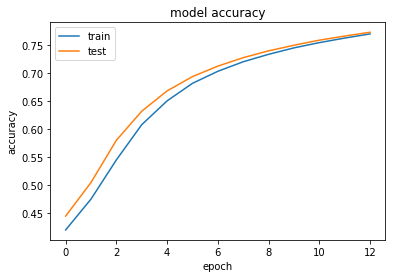

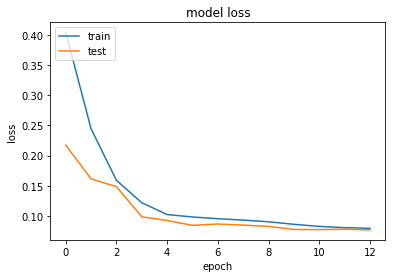

In [21]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['mean_iou'])
plt.plot(model.history.history['val_mean_iou'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Adding the data augmentation and run the saved model

In [22]:
train_aug = ImageDataGenerator(rotation_range=45.,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             vertical_flip=True,
                             fill_mode='constant')
masks_aug = ImageDataGenerator(rotation_range=45.,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             vertical_flip=True,
                             fill_mode='constant')

In [23]:
train_aug.fit(X_train, augment=True)
masks_aug.fit(Y_train, augment=True)

In [24]:
X_aug = train_aug.flow(X_train, shuffle=True, batch_size=16)
Y_aug = masks_aug.flow(Y_train, shuffle=True, batch_size=16)

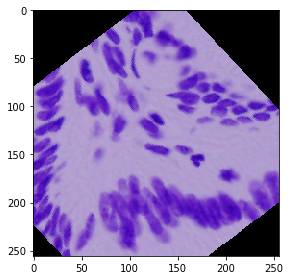

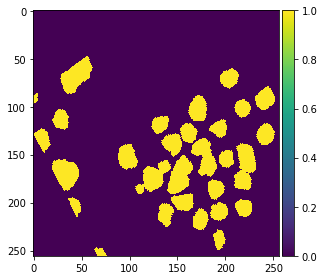

In [27]:
# checking the generated images
imshow(X_aug.next()[2].astype (np.uint8))
plt.show()
imshow(np.squeeze (Y_aug.next()[2].astype (np.uint8)))
plt.show()

In [28]:
# zip to the train generator
train_gen = zip(X_aug, Y_aug)

### Implementation of data aug

In [40]:
from sklearn.model_selection import train_test_split

In [45]:
def get_train_test_augmented(X_data=X_train, Y_data=Y_train, validation_split=0.15, batch_size=8, seed=seed):
    X_train, X_test, Y_train, Y_test = train_test_split(X_data,
                                                        Y_data,
                                                        train_size=1-validation_split,
                                                        test_size=validation_split,
                                                        random_state=seed)
    
    # Image data generator distortion options
    data_gen_args = dict(rotation_range=45.,
                         width_shift_range=0.1,
                         height_shift_range=0.1,
                         shear_range=0.2,
                         zoom_range=0.2,
                         horizontal_flip=True,
                         vertical_flip=True,
                         fill_mode='reflect')  #use 'constant'??


    # Train data, provide the same seed and keyword arguments to the fit and flow methods
    X_datagen = ImageDataGenerator(**data_gen_args)
    Y_datagen = ImageDataGenerator(**data_gen_args)
    X_datagen.fit(X_train, augment=True)
    Y_datagen.fit(Y_train, augment=True)
    X_train_augmented = X_datagen.flow(X_train, batch_size=batch_size, shuffle=True)
    Y_train_augmented = Y_datagen.flow(Y_train, batch_size=batch_size, shuffle=True)
     
    
    # Test data, no data augmentation, but we create a generator anyway
    X_datagen_val = ImageDataGenerator()
    Y_datagen_val = ImageDataGenerator()
    X_datagen_val.fit(X_test, augment=True)
    Y_datagen_val.fit(Y_test, augment=True)
    X_test_augmented = X_datagen_val.flow(X_test, batch_size=batch_size, shuffle=True)
    Y_test_augmented = Y_datagen_val.flow(Y_test, batch_size=batch_size, shuffle=True)
    
    
    # combine generators into one which yields image and masks
    train_generator = zip(X_train_augmented, Y_train_augmented)
    test_generator = zip(X_test_augmented, Y_test_augmented)
    
    return train_generator, test_generator

In [46]:
train_generator, test_generator = get_train_test_augmented(X_train, Y_train)

In [31]:
# load the old model and train from the start
model = load_model('model-dsbowl2018-1.h5', custom_objects={'mean_iou': mean_iou})


In [34]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])

In [47]:
batch_size=16
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-dsbowl2018-2.h5', verbose=1, save_best_only=True)
model.fit_generator(train_generator, validation_data=test_generator, 
                    validation_steps=batch_size/2, steps_per_epoch=len(X_train)/(batch_size*2), 
                    epochs=50, callbacks=[earlystopper, checkpointer])

Epoch 1/50
21/20 [==============================] - 228s 11s/step - loss: 0.4191 - mean_iou: 0.4377 - val_loss: 0.4176 - val_mean_iou: 0.4349
Epoch 2/50
21/20 [==============================] - 213s 10s/step - loss: 0.4195 - mean_iou: 0.4336 - val_loss: 0.4463 - val_mean_iou: 0.4325
Epoch 3/50
21/20 [==============================] - 210s 10s/step - loss: 0.4283 - mean_iou: 0.4314 - val_loss: 0.4442 - val_mean_iou: 0.4303
Epoch 4/50
21/20 [==============================] - 193s 9s/step - loss: 0.4570 - mean_iou: 0.4291 - val_loss: 0.4180 - val_mean_iou: 0.4285
Epoch 5/50
21/20 [==============================] - 209s 10s/step - loss: 0.4226 - mean_iou: 0.4283 - val_loss: 0.4165 - val_mean_iou: 0.4281
Epoch 6/50
21/20 [==============================] - 208s 10s/step - loss: 0.4396 - mean_iou: 0.4278 - val_loss: 0.4228 - val_mean_iou: 0.4273
Epoch 7/50
21/20 [==============================] - 196s 9s/step - loss: 0.4104 - mean_iou: 0.4270 - val_loss: 0.3969 - val_mean_iou: 0.4273
Epoch 8/

## Making the predictions

In [9]:
# Predict on train, val and test
model = load_model('model_u_net.h5', custom_objects={'mean_iou': mean_iou})
# preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
# preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
# preds_train_t = (preds_train > 0.5).astype(np.uint8)
# preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))



TypeError: Unexpected keyword argument passed to optimizer: amsgrad

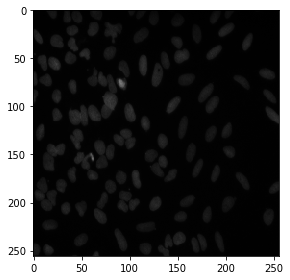

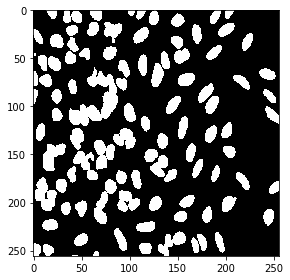

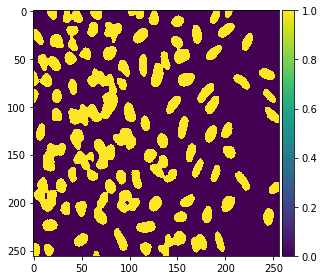

In [23]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

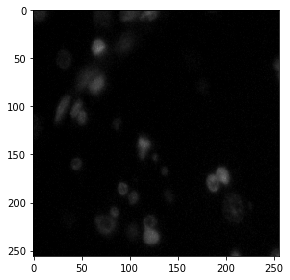

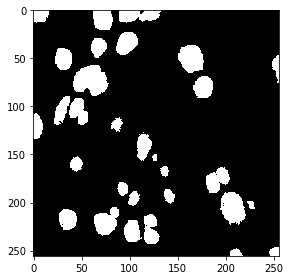

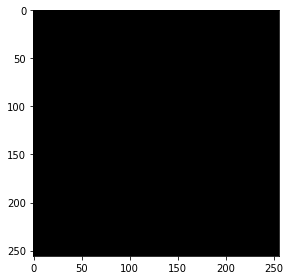

In [49]:
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

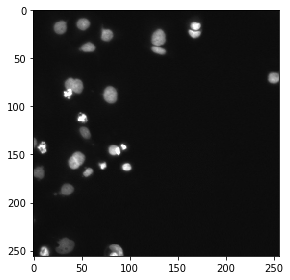

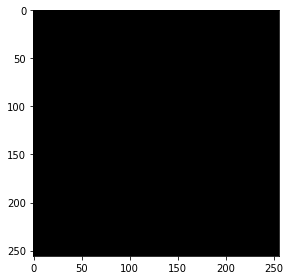

In [54]:
ix = random.randint(0, len(preds_test_t))
imshow(X_test[ix])
plt.show()

imshow(np.squeeze(preds_test_t[ix]))
plt.show()

In [50]:
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

In [51]:
new_test_ids = []
rles = []
for n, id_ in enumerate(test_ids):
    rle = list(prob_to_rles(preds_test_upsampled[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))

In [52]:
# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('sub-dsbowl2018-2.csv', index=False)